Diabetes tipe 2 merupakan penyakit kronis yang jumlah penderitanya terus meningkat di seluruh dunia. Deteksi sejak dini sangat penting untuk mencegah komplikasi serius seperti gagal ginjal, serangan jantung, dan stroke. Sayangnya, di banyak negara berkembang, alat skrining yang akurat, mudah digunakan, dan terjangkau masih sangat terbatas.

Dataset Pima Indian yang dikembangkan oleh National Institutes of Health (NIH) menyajikan berbagai pengukuran klinis dasar seperti kadar glukosa, tekanan darah, indeks massa tubuh, dan lainnya. Data ini dapat dimanfaatkan untuk membangun sistem prediksi risiko diabetes tipe 2 yang hanya bergantung pada informasi medis sederhana yang biasanya sudah tersedia di fasilitas kesehatan tingkat pertama seperti puskesmas.

Tujuan dari proyek ini adalah:
1. Mengidentifikasi pola-pola klinis yang membedakan individu dengan dan tanpa diabetes tipe 2.
2. Mengembangkan model klasifikasi yang mampu memprediksi kemungkinan seseorang mengidap diabetes berdasarkan data pemeriksaan dasar.

#### Data Understanding

In [19]:
# import necessary libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [20]:
# Load dataset
df = pd.read_csv("NIH_Diabetes.csv")

# See the info of dataset
print("Shape:", df.shape)
print(df.info())
print(df["Outcome"].value_counts(), "\n")

Shape: (768, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
Outcome
0    500
1    268
Name: count, dtype: int64 



In [21]:
# Descriptive statistics of dataset
display(df.describe())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [22]:
# Check unique value and null/0
for col in ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]:
    zeros = (df[col] == 0).sum()
    print(f"{col}: {zeros} nilai = 0")

Glucose: 5 nilai = 0
BloodPressure: 35 nilai = 0
SkinThickness: 227 nilai = 0
Insulin: 374 nilai = 0
BMI: 11 nilai = 0


Informasi Dataset:

- Dataset ini berisi 768 baris data (masing-masing mewakili satu pasien) dan 9 kolom fitur. Ukurannya tergolong kecil, sehingga cukup ideal untuk eksplorasi data secara manual dan pembuatan model prediksi secara cepat.
- Tidak ada nilai kosong (missing value) yang tercatat secara eksplisit. Namun, hal ini tidak serta-merta berarti bahwa seluruh datanya valid. Beberapa kolom ternyata memiliki nilai nol, dan ini perlu diperiksa lebih lanjut.
- Penting untuk dicermati bahwa nilai nol belum tentu valid untuk semua fitur. Nilai nol bisa saja menandakan data yang sebenarnya hilang atau tidak dicatat dengan benar.

Berikut adalah fitur-fitur yang secara medis tidak mungkin bernilai nol:

1. Glukosa (Glucose)
Nilai nol pada kolom ini tidak masuk akal. Tubuh manusia selalu memiliki glukosa dalam darah, bahkan saat berpuasa. Jika nilai glukosa tercatat sebagai nol, berarti tidak ada glukosa dalam darah, yang tidak mungkin terjadi pada manusia hidup. Dalam konteks tes toleransi glukosa (OGTT), nilai normal berada di kisaran 70–99 mg/dL.

2. Tekanan Darah (BloodPressure)
Kolom ini merepresentasikan tekanan darah diastolik, yaitu tekanan saat jantung beristirahat antara dua detakan. Nilai nol menunjukkan tidak adanya tekanan darah, yang secara medis menandakan kematian. Normalnya, tekanan diastolik berada di kisaran 60–80 mmHg.

3. Ketebalan Kulit (SkinThickness)
Pengukuran ini menggambarkan ketebalan lipatan kulit di bagian triseps sebagai indikator lemak subkutan. Dalam kondisi normal, nilai ini tidak pernah nol, karena tubuh manusia selalu memiliki jaringan lemak di bawah kulit. Pengukuran dilakukan dalam satuan milimeter menggunakan alat khusus bernama skinfold caliper.

4. Insulin
Hormon insulin diukur dalam satuan μU/ml melalui tes darah. Tidak ada individu hidup dengan kadar insulin nol. Oleh karena itu, nilai nol pada kolom ini kemungkinan besar menunjukkan data yang hilang atau tidak tersedia saat pemeriksaan.

5. Indeks Massa Tubuh (BMI)
BMI dihitung dari pembagian berat badan dengan kuadrat tinggi badan. Nilai nol berarti pasien tidak memiliki berat atau tinggi badan, yang tentu mustahil secara fisik. Secara umum, nilai BMI paling rendah yang masih realistis biasanya berada di atas angka 10.

Kesimpulan:
Nilai-nilai nol pada kolom-kolom tersebut sangat besar kemungkinan mencerminkan data yang hilang, bukan nilai yang sah. Oleh karena itu, perlu dilakukan proses imputasi sebelum digunakan dalam pemodelan.

#### Data Cleaning & Reprocessing

In [23]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Change 0 with NaN
cols_missing = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
df[cols_missing] = df[cols_missing].replace(0, np.nan)

In [24]:
# Median imputation
imputer = SimpleImputer(strategy="median")
df[cols_missing] = imputer.fit_transform(df[cols_missing])

In [25]:
# Check NaN
print(df[cols_missing].isna().sum())

Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64


#### Exploratory Data Analysis

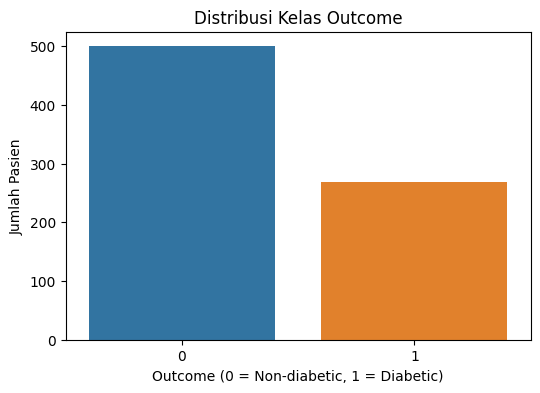

In [26]:
# Outcome Distribution

plt.figure(figsize=(6,4))
sns.countplot(x="Outcome", data=df)
plt.title("Distribusi Kelas Outcome")
plt.xlabel("Outcome (0 = Non-diabetic, 1 = Diabetic)")
plt.ylabel("Jumlah Pasien")
plt.show()

Tujuan dari analisis distribusi kelas ini adalah untuk memahami sebaran jumlah pasien dengan dan tanpa diabetes. Informasi ini penting sebagai dasar pertimbangan apakah perlu dilakukan penyeimbangan kelas (balancing), misalnya dengan menggunakan metode seperti SMOTE.

Dari grafik yang ditampilkan, terlihat bahwa mayoritas pasien berada pada kategori non-diabetes (Outcome = 0) dengan proporsi sekitar 65 persen. Sementara itu, pasien dengan diabetes (Outcome = 1) hanya sekitar 35 persen. Ketimpangan ini dikenal sebagai class imbalance.

Ketidakseimbangan kelas bisa menjadi masalah serius dalam pemodelan prediktif. Banyak algoritma, terutama yang tidak mempertimbangkan bobot kelas, cenderung lebih mudah mencapai akurasi tinggi hanya dengan menebak kelas yang paling dominan, dalam hal ini, kelas 0. Namun, model semacam ini justru berisiko mengabaikan kasus diabetes (kelas 1) yang sebenarnya jauh lebih penting untuk dideteksi secara dini. Karena itu, sangat disarankan untuk menerapkan metode balancing agar model lebih adil dalam mengenali kedua kelas.

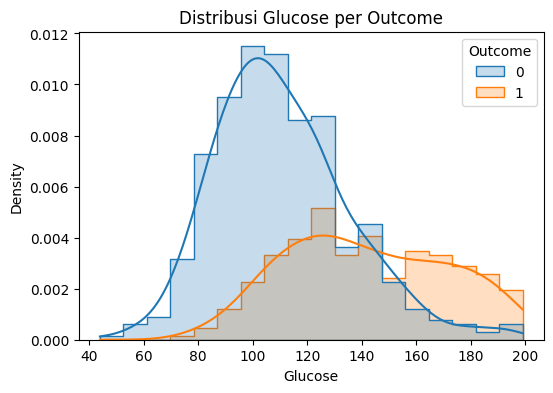

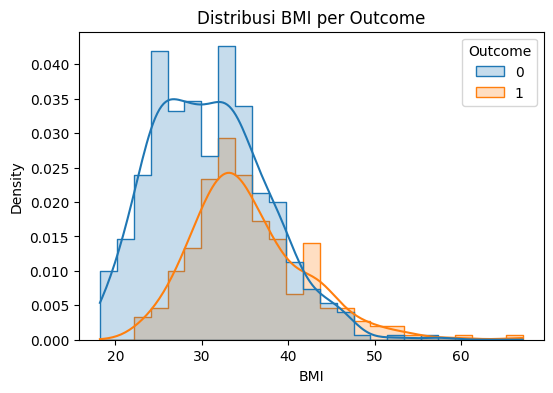

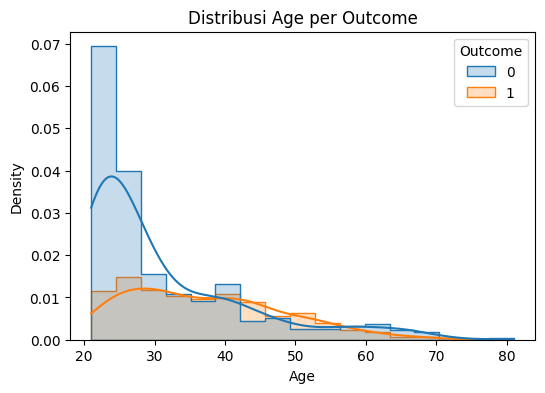

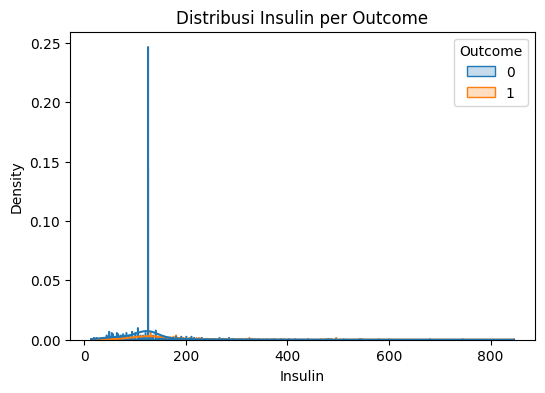

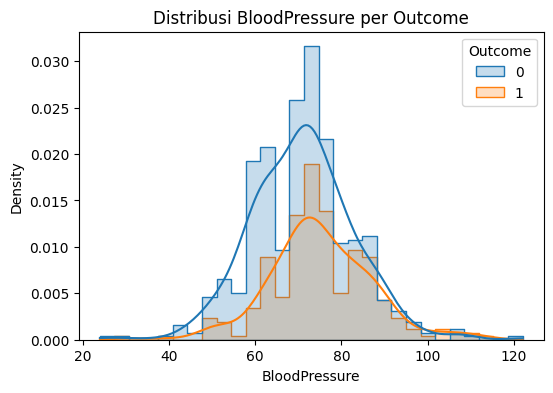

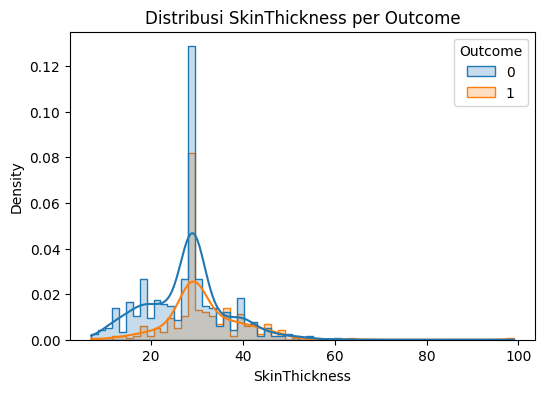

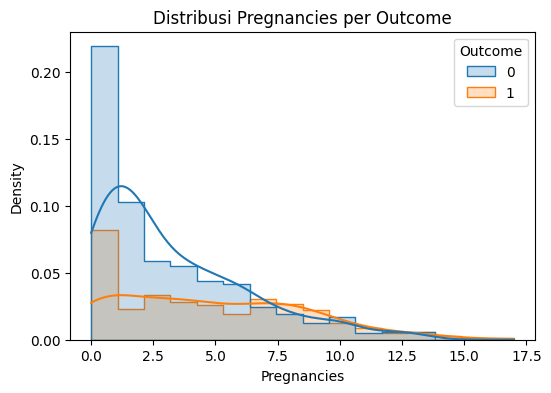

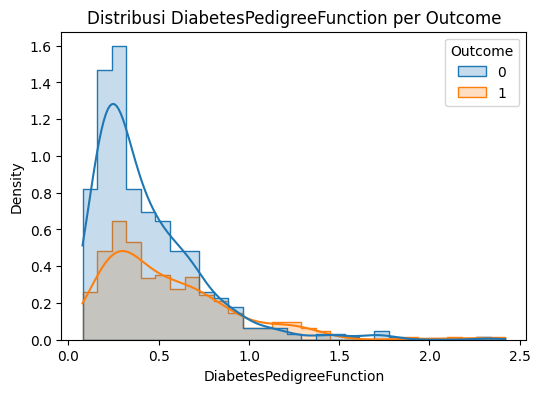

In [27]:
# Feature Distribution by Outcome

features = ["Glucose", "BMI", "Age", "Insulin",
            "BloodPressure", "SkinThickness", "Pregnancies", "DiabetesPedigreeFunction"]
for col in features:
    plt.figure(figsize=(6,4))
    sns.histplot(data=df, x=col, hue="Outcome", kde=True, element="step", stat="density")
    plt.title(f"Distribusi {col} per Outcome")
    plt.show()

Dari visualisasi distribusi kadar glukosa berdasarkan kelas outcome, terlihat dengan jelas bahwa kurva densitas untuk pasien yang didiagnosis diabetes (Outcome = 1) bergeser ke arah kanan dibandingkan dengan pasien non-diabetes. Artinya, kelompok pasien diabetes cenderung memiliki kadar glukosa darah yang lebih tinggi.

Perbedaan pola ini tidak sejelas pada fitur-fitur lain, sehingga glukosa menjadi salah satu indikator yang paling menonjol dalam membedakan kedua kelompok. Temuan ini memperkuat pemahaman bahwa kadar glukosa darah yang tinggi merupakan faktor risiko utama dalam penentuan diagnosis diabetes tipe 2.

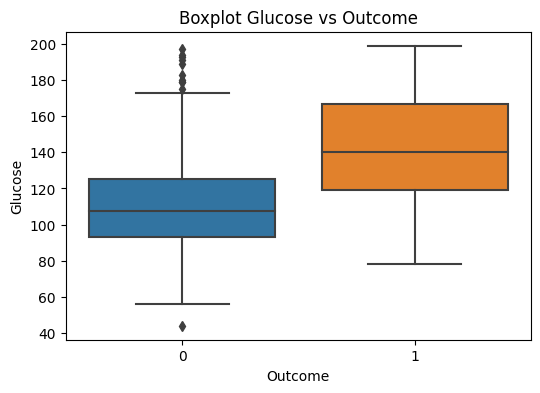

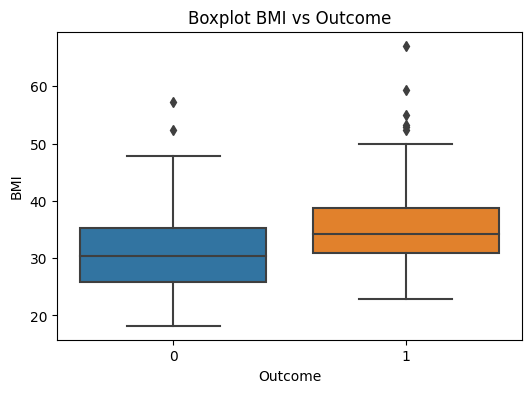

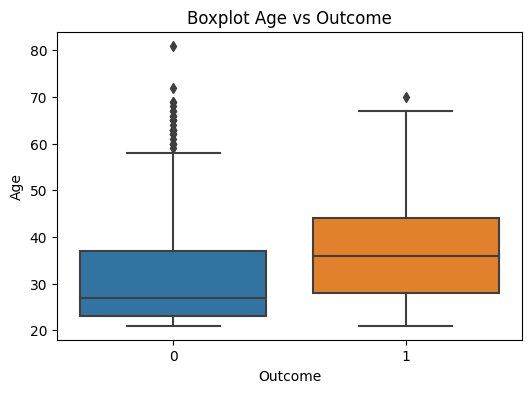

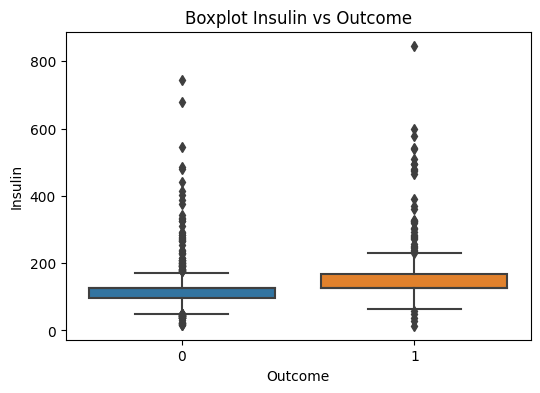

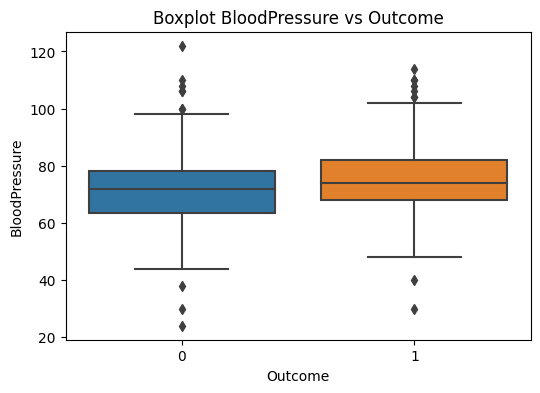

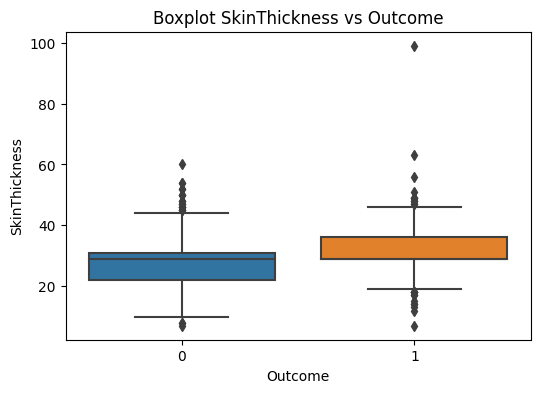

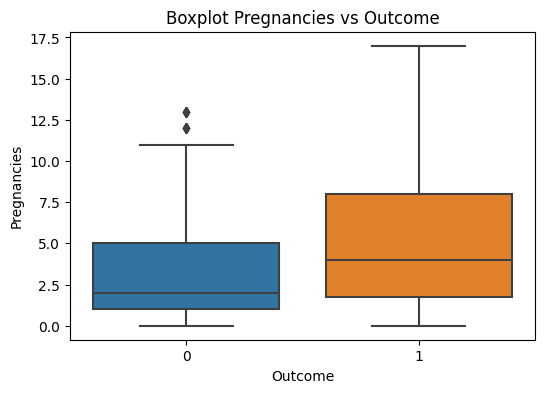

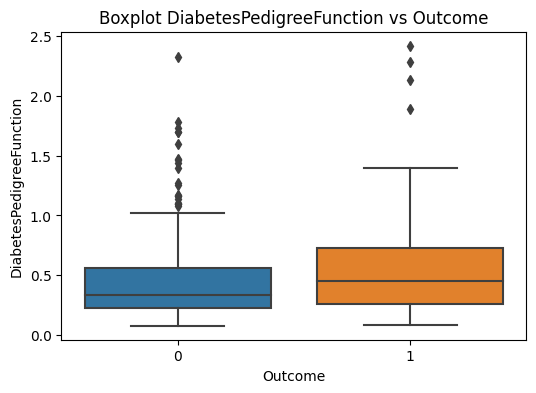

In [28]:
# Boxplot

for col in features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="Outcome", y=col, data=df)
    plt.title(f"Boxplot {col} vs Outcome")
    plt.show()

Memang sebagian besar fitur cenderung menunjukkan nilai yang lebih tinggi pada pasien dengan Outcome = 1. Namun, jika dilihat pada boxplot untuk fitur Glucose, terlihat bahwa median dan rentang antar-kuartil (IQR) pada kelompok pasien diabetes berada jauh lebih tinggi dibanding kelompok non-diabetes.

Perbedaan yang mencolok ini semakin menegaskan bahwa kadar glukosa darah merupakan salah satu pembeda paling signifikan antara pasien yang terdiagnosis diabetes dan yang tidak. Glucose menjadi fitur yang paling jelas memberikan indikasi terhadap keberadaan diabetes dalam data ini.


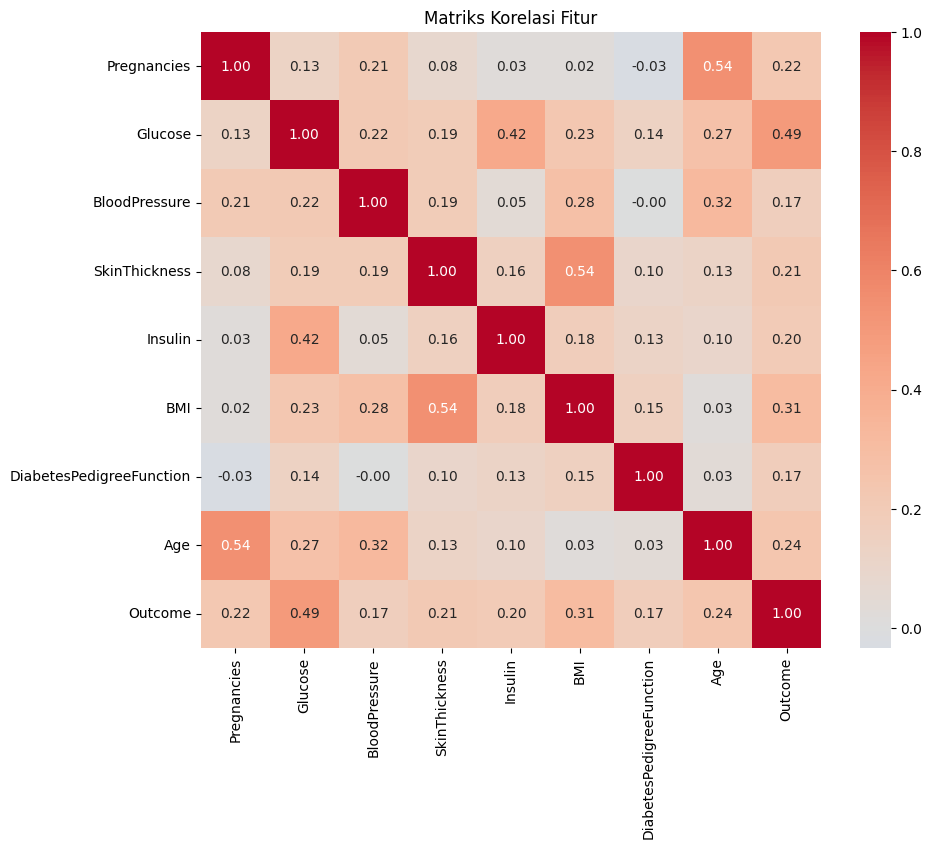

In [29]:
# Feature correlation

corr = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Matriks Korelasi Fitur")
plt.show()

1. Korelasi Fitur terhadap Outcome

Di antara semua fitur, glukosa memiliki korelasi tertinggi dengan outcome, yaitu sebesar 0.49. Ini semakin memperkuat bahwa kadar glukosa darah adalah indikator paling kuat dalam memprediksi risiko diabetes. BMI memiliki korelasi sebesar 0.31, menunjukkan hubungan yang cukup kuat dan relevan, sejalan dengan pemahaman bahwa obesitas turut berkontribusi dalam perkembangan diabetes tipe 2.

Beberapa fitur lain seperti usia (0.24), jumlah kehamilan (0.22), ketebalan kulit (0.21), dan insulin (0.20) juga memiliki hubungan yang cukup berarti, meskipun tidak sekuat dua fitur utama. Sementara itu, tekanan darah dan diabetes pedigree function menunjukkan korelasi yang lebih rendah, masing-masing sebesar 0.17. Artinya, meskipun bisa saja berperan, kontribusinya terhadap prediksi outcome cenderung lebih terbatas.

2. Multikolinearitas antar Fitur

Terdapat beberapa pasangan fitur yang memiliki korelasi cukup tinggi satu sama lain. Misalnya, SkinThickness dan BMI memiliki korelasi sebesar 0.54. Hal ini masuk akal karena keduanya sama-sama berkaitan dengan kadar lemak tubuh, sehingga bisa menimbulkan redundansi dalam model. Hal serupa juga terjadi antara Pregnancies dan Age dengan korelasi 0.54, yang menggambarkan bahwa perempuan dengan usia lebih tua cenderung memiliki riwayat kehamilan yang lebih banyak.

Korelasi antara glukosa dan insulin tercatat sebesar 0.42. Meskipun tidak tergolong sangat tinggi, hubungan ini tetap logis karena insulin berperan langsung dalam pengolahan glukosa di tubuh. Korelasi-korelasi semacam ini penting untuk dipertimbangkan dalam pemodelan agar tidak terjadi duplikasi informasi yang bisa memengaruhi performa model.

#### Feature Engineering

In [30]:
# Scaling numeric features
from sklearn.preprocessing import StandardScaler

num_feats = ["Pregnancies","Glucose","BloodPressure","SkinThickness",
             "Insulin","BMI","DiabetesPedigreeFunction","Age"]
scaler    = StandardScaler()
df[num_feats] = scaler.fit_transform(df[num_feats])

In [31]:
# Feature Selection: Mutual Information

from sklearn.feature_selection import mutual_info_classif

X = pd.get_dummies(df.drop("Outcome", axis=1), drop_first=True)
mi = mutual_info_classif(X, df["Outcome"], random_state=42)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print("Top 10 MI features:\n", mi_series.head(10))

Top 10 MI features:
 Glucose                     0.117733
BMI                         0.081040
Pregnancies                 0.061636
Age                         0.051395
DiabetesPedigreeFunction    0.014590
Insulin                     0.012804
SkinThickness               0.012372
BloodPressure               0.001763
dtype: float64


In [32]:
# Feature Selection: Feature Importance with Random Forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, df["Outcome"])
imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top 10 RF importances:\n", imp.head(10))

Top 10 RF importances:
 Glucose                     0.263715
BMI                         0.167470
Age                         0.127208
DiabetesPedigreeFunction    0.124075
Insulin                     0.084843
BloodPressure               0.082722
Pregnancies                 0.079268
SkinThickness               0.070699
dtype: float64


1. Mutual Information

Mutual information digunakan untuk mengukur seberapa besar ketergantungan antara masing-masing fitur dengan target (Outcome). Semakin tinggi nilainya, semakin banyak informasi yang dimiliki fitur tersebut dalam membantu memprediksi outcome. Dari hasil analisis, fitur Glucose memiliki nilai tertinggi yaitu 0.109. Ini menunjukkan bahwa glukosa merupakan fitur yang paling informatif dan sangat berpengaruh dalam memprediksi risiko diabetes.

Selain itu, BMI juga muncul sebagai salah satu fitur yang penting. Sementara itu, fitur lain seperti BloodPressure, SkinThickness, dan DiabetesPedigreeFunction tetap memberikan kontribusi, meskipun nilainya relatif kecil dibanding fitur utama.

2. Feature Importance dari Random Forest

Metode Random Forest mengukur pentingnya fitur berdasarkan seberapa besar penurunan ketidakteraturan (impurity) yang dihasilkan saat membuat keputusan dalam pohon. Fitur yang memberikan penurunan impurity terbesar dianggap paling penting. Hasilnya menunjukkan bahwa Glucose, BMI, dan Age kembali menempati posisi teratas sebagai fitur yang paling berpengaruh dalam model.

Menariknya, algoritma ini juga menilai bahwa DiabetesPedigreeFunction dan Insulin memiliki peran yang cukup besar, walaupun sebelumnya tidak terlalu menonjol dalam analisis mutual information.

Kesimpulan Feature Selection

Secara keseluruhan, hasil dari berbagai metode seleksi fitur menunjukkan pola yang konsisten. Glucose, BMI, dan Age selalu muncul sebagai fitur yang paling penting dan relevan untuk memprediksi kemungkinan seseorang mengidap diabetes.

#### Data Splitting and Balancing

In [33]:
# Split Data

from sklearn.model_selection import train_test_split

X = pd.get_dummies(df.drop("Outcome", axis=1), drop_first=True)
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [34]:
# Check target distribution

print("Train:", y_train.value_counts(normalize=True))
print("Test :", y_test.value_counts(normalize=True))

Train: Outcome
0    0.651466
1    0.348534
Name: proportion, dtype: float64
Test : Outcome
0    0.649351
1    0.350649
Name: proportion, dtype: float64


Pada data train dan test, proporsi kelas 0 tercatat sekitar 65 persen, sedangkan kelas 1 sekitar 35 persen. Komposisi ini hampir identik di kedua bagian data, yang menunjukkan bahwa proses stratifikasi telah berjalan dengan baik.

Namun, distribusi ini tetap tergolong tidak seimbang. Ketimpangan jumlah antara kelas mayoritas dan minoritas bisa menyebabkan model cenderung bias terhadap kelas yang lebih dominan. Oleh karena itu, perlu dilakukan penyeimbangan kelas pada data latih agar model mampu mengenali kedua kelas secara adil dan tidak mengabaikan kasus diabetes yang jumlahnya lebih sedikit tapi jauh lebih penting untuk dideteksi.

In [35]:
# SMOTE (Synthetic Minority Over-sampling Technique)

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("After SMOTE:", y_train_res.value_counts())

After SMOTE: Outcome
0    400
1    400
Name: count, dtype: int64


#### Modeling

In [36]:
# Model Baseline

from sklearn.linear_model    import LogisticRegression
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from xgboost                 import XGBClassifier

models = {
    "LogisticRegression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "KNN":                KNeighborsClassifier(),
    "DecisionTree":       DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "RandomForest":       RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42),
    "XGBoost":            XGBClassifier(scale_pos_weight=(y_train.value_counts()[0]/y_train.value_counts()[1]), use_label_encoder=False, eval_metric='logloss')
}

In [37]:
# Training and evaluation

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

results = []
for name, model in models.items():
    # Latih
    model.fit(X_train_res, y_train_res)
    # Prediksi
    y_pred = model.predict(X_test)
    y_proba= model.predict_proba(X_test)[:,1]
    # Metrik
    results.append({
        "Model": name,
        "Accuracy":  accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall":    recall_score(y_test, y_pred),
        "F1":        f1_score(y_test, y_pred),
        "ROC_AUC":   roc_auc_score(y_test, y_proba)
    })

import pandas as pd
results_df = pd.DataFrame(results).sort_values(by="ROC_AUC", ascending=False)
print(results_df)

                Model  Accuracy  Precision    Recall        F1   ROC_AUC
4             XGBoost  0.759740   0.630769  0.759259  0.689076  0.824630
3        RandomForest  0.733766   0.603175  0.703704  0.649573  0.818704
0  LogisticRegression  0.720779   0.587302  0.685185  0.632479  0.810926
1                 KNN  0.694805   0.549296  0.722222  0.624000  0.783333
2        DecisionTree  0.720779   0.600000  0.611111  0.605505  0.695556


Secara keseluruhan, XGBoost menjadi model dengan performa terbaik dibanding model lainnya. Model ini mencatat skor tertinggi pada semua metrik evaluasi utama, mulai dari akurasi, recall, F1-score, hingga ROC AUC.

Nilai recall sebesar 0.76 menunjukkan bahwa XGBoost paling baik dalam mengenali kasus positif, yaitu pasien yang mengidap diabetes. Dalam konteks medis, kemampuan ini sangat penting karena tujuannya adalah meminimalkan jumlah kasus yang tidak terdeteksi agar tidak terjadi keterlambatan penanganan.

In [39]:
# Using the model - XGBoost

data_baru = {
    "Pregnancies": 2,
    "Glucose": 140,
    "BloodPressure": 70,
    "SkinThickness": 20,
    "Insulin": 85,
    "BMI": 33.6,
    "DiabetesPedigreeFunction": 0.627,
    "Age": 50
}

df_baru = pd.DataFrame([data_baru])

df_baru_scaled = scaler.transform(df_baru)

prediksi = models["XGBoost"].predict(df_baru_scaled)
probabilitas = models["XGBoost"].predict_proba(df_baru_scaled)[:, 1]

hasil = "Diabetes" if prediksi[0] == 1 else "Tidak Diabetes"
print(f"Hasil Prediksi: {hasil}")
print(f"Probabilitas Diabetes: {probabilitas[0]:.4f}")

Hasil Prediksi: Diabetes
Probabilitas Diabetes: 0.7892


In [46]:
# Save the models

import joblib

joblib.dump({"XGBoost": models["XGBoost"]}, "models.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']